=== Per-goal evaluation (Weighted A*) ===
            goal  success_rate_%  efficiency_mean  replan_latency_ms  nodes_expanded_mean
     Candy Store           100.0            0.981              1.959                134.5
      Magic Show           100.0            0.988             43.952               2784.0
Musical Fountain           100.0            1.000                NaN               1580.0
   Souvenir Shop           100.0            1.000                NaN                 74.0
     Water Slide           100.0            1.000                NaN                175.0

=== Overall summary (across all goals) ===
   value
 100.000
  22.956
1095.143
   0.991


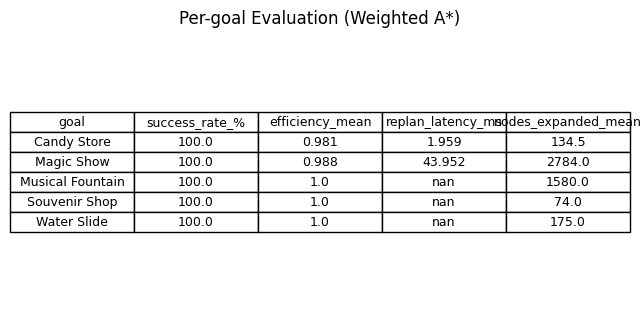

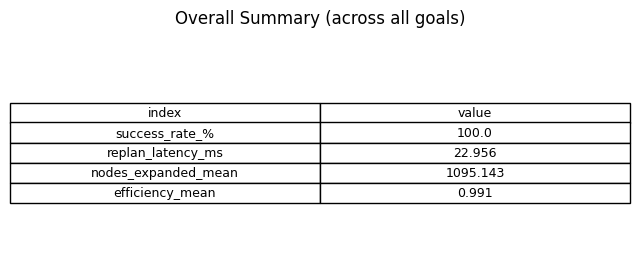

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv("astar_metrics.csv")

df = df[df["id"].astype(str).str.lower() != "anon"].copy()

for col in ["ok", "is_replan"]:
    df[col] = df[col].astype(int)

base = (
    df[(df["ok"] == 1) & (df["is_replan"] == 0)]
    .groupby("goal", as_index=True)["path_len_m"]
    .min()
    .rename("baseline_len")
)

df = df.merge(base, left_on="goal", right_index=True, how="left")

df["efficiency"] = np.where(
    (df["ok"] == 1) & np.isfinite(df["baseline_len"]) & (df["baseline_len"] > 0),
    df["path_len_m"] / df["baseline_len"],
    np.nan
)

def _safe_mean(s):
    return float(s.mean()) if len(s) else np.nan

goal_stats = (
    df.groupby("goal")
      .apply(lambda g: pd.Series({
          # 1) Success rate
          "success_rate_%": 100.0 * _safe_mean(g["ok"]),

          # 2) Replan latency 
          "replan_latency_ms": _safe_mean(g.loc[g["is_replan"] == 1, "plan_time_ms"]),

          # 3) Computation load
          "nodes_expanded_mean": _safe_mean(g["nodes_expanded"]),

          # 4) Path efficiency
          "efficiency_mean": _safe_mean(g["efficiency"]),
      }), include_groups=False)
      .reset_index()
)

overall = pd.Series({
    "success_rate_%":      100.0 * _safe_mean(df["ok"]),
    "replan_latency_ms":   _safe_mean(df.loc[df["is_replan"] == 1, "plan_time_ms"]),
    "nodes_expanded_mean": _safe_mean(df["nodes_expanded"]),
    "efficiency_mean":     _safe_mean(df["efficiency"]),
}).to_frame("value")

cols_order = [
    "goal",
    "success_rate_%",
    "efficiency_mean",
    "replan_latency_ms",
    "nodes_expanded_mean",
]
goal_stats = goal_stats[cols_order].sort_values("goal")

print("=== Per-goal evaluation (Weighted A*) ===")
print(goal_stats.round(3).to_string(index=False))

print("\n=== Overall summary (across all goals) ===")
print(overall.round(3).to_string(index=False))

import matplotlib.pyplot as plt

def render_table(df, title, fname=None):
    fig, ax = plt.subplots(figsize=(8, len(df)*0.5 + 1))
    ax.axis("off")
    table = ax.table(cellText=df.round(3).values,
                     colLabels=df.columns,
                     cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)
    ax.set_title(title, fontsize=12, pad=10)
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

render_table(goal_stats, "Per-goal Evaluation (Weighted A*)", "goal_stats_table.png")
render_table(overall.reset_index(), "Overall Summary (across all goals)", "overall_table.png")